In [5]:
!pip3 install https://download.pytorch.org/whl/cu80/torch-1.0.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install torchsummary
!pip3 install tensorboardX

from google.colab import drive
drive.mount('/content/gdrive')
!cp gdrive/My\ Drive/x64/*.npy .
!cp gdrive/My\ Drive/*.py .
!ls -l

    100% |████████████████████████████████| 133kB 4.7MB/s 
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 949904
drwxr-xr-x 3 root root      4096 Mar 28 10:34 data
-rw------- 1 root root      2875 Mar 28 15:24 _dataset_tools.py
drwx------ 3 root root      4096 Mar 28 11:07 gdrive
-rw------- 1 root root      2481 Mar 28 15:24 _my_tools.py
drwxr-xr-x 2 root root      4096 Mar 28 15:19 __pycache__
drwxr-xr-x 1 root root      4096 Mar  8 17:26 sample_data
-rw------- 1 root root 129687680 Mar 28 15:23 X_test.npy
-rw------- 1 root root 518750336 Mar 28 15:24 X_train.npy
-rw------- 1 root root  64843904 Mar 28 15:24 y_test.npy
-rw------- 1 root root 259375232 Mar 28 15:24 y_train.npy


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from tensorboardX import SummaryWriter
from torchsummary import summary

import _my_tools as mt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is", device)
# X_train, y_train, X_test, y_test = mt.loadData("",'float16',channels_last=False)

Device is cuda:0


In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.KERNEL_SIZE = 31
        self.activation = nn.ReLU()
        
        self.conv_setup = {
            'kernel' : (3,3),
            'stride' : (1,1),
            'padding' : 1,
            'activation' : self.activation
        }
        self.pooling_setup = {
            'kernel_size' : (2,2),
            'stride' : (2,2)
        }
        self.upsample_setup = {
            'scale_factor' : 2,
            'mode' : 'bilinear',
            'align_corners' : True
        }

        self.pooling_layer = nn.AvgPool2d(**self.pooling_setup)
        self.upsample_layer = nn.Upsample(**self.upsample_setup)
        
        self.conv32 = self._convBlock(2, 32, **self.conv_setup)
        self.conv64 = self._convBlock(32, 64, **self.conv_setup)
        self.conv128 = self._convBlock(64, 128, **self.conv_setup)
        self.conv256 = self._convBlock(128, 256, **self.conv_setup)
        self.conv256_256 = self._convBlock(256, 256, **self.conv_setup)


        self.upsample256 = self._upsampleBlock(self.upsample_layer, 256, 256, **self.conv_setup)
        self.deconv128 = self._convBlock(256, 128, **self.conv_setup)
        self.upsample128 = self._upsampleBlock(self.upsample_layer, 128, 128, **self.conv_setup)
        self.deconv64 = self._convBlock(128, 64, **self.conv_setup)
        self.upsample64 = self._upsampleBlock(self.upsample_layer, 64, 64, **self.conv_setup)
        self.deconv32 = self._convBlock(64, 32, **self.conv_setup)
        self.upsample32 = self._upsampleBlock(self.upsample_layer, 32, 32, **self.conv_setup)
        self.deconv1 = self._convBlock(32, 1, **self.conv_setup)
        
    def forward(self, x):
        x32 = self.conv32(x)
        x32_p = self.pooling_layer(x32)
        x64 = self.conv64(x32_p)
        x64_p = self.pooling_layer(x64)
        x128 = self.conv128(x64_p)
        x128_p = self.pooling_layer(x128)
        x256 = self.conv256(x128_p)
        x256_p = self.pooling_layer(x256)

        x = self.conv256_256(x256_p)

        # expansion

        x = self.upsample256(x)
        x += x256
        x = self.deconv128(x)

        x = self.upsample128(x)
        x += x128
        x = self.deconv64(x)

        x = self.upsample64(x)
        x += x64
        x = self.deconv32(x)
        
        x = self.upsample32(x)
        x += x32
        x = self.deconv1(x)
        
        return x
    
    @staticmethod
    def _convBlock(in_channels, out_channels, kernel, stride, padding, activation):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), activation,
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), activation,
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding), activation
        )
    @staticmethod
    def _upsampleBlock(upsample, in_channels, out_channels, kernel, stride, padding, activation):
        return nn.Sequential(
            upsample,
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding), activation
        )

model = Model()
# print(model)
print(summary(model.cuda(), (2,64,64)))
    
# --------------------------------------------------------------------------------------------------

def getLossOptimizer(net, learning_rate=0.001):
    loss_function = nn.L1Loss()
    optimizer = optim.Adamax(net.parameters(), lr=learning_rate)
    
    return (loss_function, optimizer)

def getBatch(X, y, offset, batch_size, device):
    input = torch.tensor( X[ offset:offset + batch_size ], dtype=torch.float)
    target = torch.tensor( y[ offset:offset + batch_size ], dtype=torch.float)
    return input.to(device), target.to(device)

In [17]:
import time

def fit(model, device, X, y, batch_size, n_epochs, val=None):
    
    #Print all of the hyperparameters of the training iteration:
    print("====== HYPERPARAMETERS ======")
    print("batch_size =", batch_size)
    print("epochs =", n_epochs)
#     print("X shape -", X.shape)
#     print("y shape -", y.shape)
    print("=" * 29)
    
    assert X.shape[0] == y.shape[0]
    assert X.shape[2:4] == y.shape[2:4]
    
    model.to(device)
    loss_function, optimizer = getLossOptimizer(model)
    n_batch = X.shape[0] // batch_size
    
    training_start_T = time.time()
    epoch_loss = 0
    
    for epoch in range(n_epochs):
        print("===> Epoch[{}]".format(epoch), end='', flush=True)
        for it in range(n_batch):
            input, target = getBatch(X, y, it, batch_size, device)
            
            optimizer.zero_grad()
            
            output = model(input)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            
            loss_val = loss.item()
            epoch_loss += loss_val

            print("\r", end='')
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}\tETA:{}\tEpoch Loss: {:.4f}"
                  .format(epoch, it, n_batch, loss_val,"00:43", epoch_loss / (it+1)), end='', flush=True)
            
        print("Epoch[{}] finished.".format(epoch))
        
        if val is tuple:
            X_val, y_val = val
            assert X_val.shape[0] == y_val.shape[0]
            
            total_loss_val = 0
            n_batch_val = X_val.shape[0] // batch_size
            
            print("Validating on {} samples.".format(n_batch_val * batch_size))
            
            for it in range(n_batch_val):
                input, target = getBatch(X_val, y_val, it, batch_size, device)
                
                output = model(input)
                loss_val = loss_function(output, target)
                total_loss_val += loss_val.data[0]
                
            print("Validation loss = {:.4f}".format(total_loss_val / n_batch_val))
            
        elif val is not None:
            print("Cannot validate. Tuple (X_val, y_val) expected.")



fit(model, device, X_train, y_train, 128, 2)

====== HYPERPARAMETERS ======
batch_size = 128
epochs = 2
===> Epoch[0]

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


===> Epoch[0](8/494): Loss: 0.0902	ETA:00:43	Epoch Loss: 0.0899

KeyboardInterrupt: ignored

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

100%|█████████▉| 170450944/170498071 [00:41<00:00, 4770928.20it/s]

Files already downloaded and verified


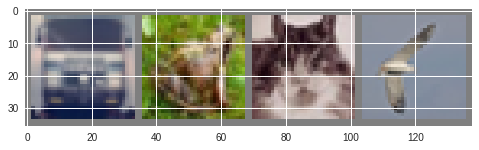

truck  frog   cat  bird


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(summary(net.cuda(), (3,32,32)))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------
None


In [19]:

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.251
[1,  4000] loss: 1.912
[1,  6000] loss: 1.686
[1,  8000] loss: 1.571
[1, 10000] loss: 1.517
[1, 12000] loss: 1.437
[2,  2000] loss: 1.385
[2,  4000] loss: 1.362
[2,  6000] loss: 1.344
[2,  8000] loss: 1.306
[2, 10000] loss: 1.250
[2, 12000] loss: 1.248
Finished Training


In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Visualization

In [0]:
from graphviz import Digraph
import torch
from torch.autograd import Variable


# make_dot was moved to https://github.com/szagoruyko/pytorchviz
from torchviz import make_dot

### First play

In [14]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net)
# print(summary(net, (1,32,32)))
print(summary(net.cuda(), (1,28,28)))

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimate

In [0]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


In [0]:
input = torch.tensor(X_train[0:2], dtype=torch.float)
out = net(input)
target = torch.tensor(y_train[0:2], dtype=torch.float)
print(out)
print(target)

tensor([[ 4.3331,  1.9793,  2.6187,  0.6244, -0.2817, -2.9674, -1.3366,  2.2282,
          2.5437, -0.4990],
        [ 5.5507,  1.4275,  2.2521, -2.5445, -2.0108, -4.9094, -0.9845,  3.9079,
          0.0534,  1.6705]], grad_fn=<AddmmBackward>)
tensor([[5.],
        [0.]])


In [0]:
net.zero_grad()

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([-0.1084,  0.1247, -0.0140,  0.0410,  0.0010,  0.0325])


In [0]:
optimizer = optim.SGD(net.parameters(), lr=0.01)

n_b = 16

for i in range(0,X_train.shape[0],n_b):
    input = torch.tensor(X_train[i:i+n_b], dtype=torch.float)
    target = torch.tensor(y_train[i:i+n_b], dtype=torch.float)

    optimizer.zero_grad()
    output = net(input)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

In [0]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [0]:
X_train = X_train.reshape([-1,1,28,28])
y_train = y_train.reshape([-1,1])
# a.shape

In [0]:
X_train[0]

array([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           3,  18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,
           0,   0,   0